<center><h2>Sentence Clustering<h2><center>
The aim of this notebook is to perform sentence clustering using TD-IDF vectorization and kmeans clustering.

## Import libraries

In [81]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.util import ngrams
import en_core_web_sm
from nltk.corpus import words
import warnings
from matplotlib import pyplot
import numpy as np
import codecs
import unidecode
import re
import spacy
import collections
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pprint import pprint

nlp = spacy.load('en_core_web_sm')
%matplotlib inline

warnings.filterwarnings('ignore')

model= en_core_web_sm.load()


pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words('english')

# Lemmatizer
wn = nltk.WordNetLemmatizer()

## Data

In [82]:
data = pd.read_csv('../Data/DataSet.csv')
data.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbreaking and award-winning cooking site. We support,...","<p>Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and...",<ul>\r\n<li>Experience with content management systems a major plus (any blogging counts!)</li>\...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Production Service.</h3>\r\n<p>90 Seconds is the worlds C...",<p>Organised - Focused - Vibrant - Awesome!<br><br>Do you have a passion for customer service? S...,<p><b>What we expect from you:</b></p>\r\n<p>Your key responsibility will be to communicate with...,<h3><b>What you will get from us</b></h3>\r\n<p>Through being part of the 90 Seconds team you wi...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f


In [83]:
print("Unique locations", len(data.location.unique()))
print("Unique job titles", len(data.title.unique()))
print("Unique industries", len(data.industry.unique()))

Unique locations 3106
Unique job titles 11231
Unique industries 132


## Data Visualization

Visualizing how does the frequency of fraudulent vary across different columns, here the idea was to understand if any column has a good balance of fradulant and legit information

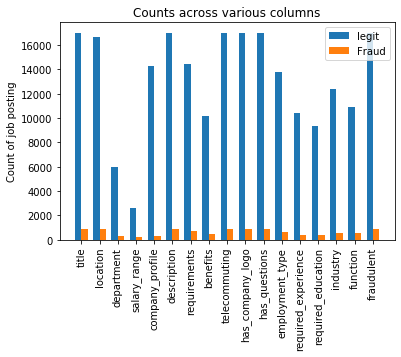

In [84]:
legit = data[data['fraudulent'] == 'f'].groupby(["fraudulent"]).agg('count').values.tolist()[0]
fraud = data[data['fraudulent'] == 't'].groupby(["fraudulent"]).agg('count').values.tolist()[0]

ind = np.arange(len(data.columns)-1)

width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2,legit, width,label='legit')
rects2 = ax.bar(ind + width/2, fraud, width,
                label='Fraud')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count of job posting')
ax.set_title('Counts across various columns')
ax.set_xticks(ind)
ax.set_xticklabels(data.columns, rotation=90)
ax.legend()

In [85]:
# merge all description columns
data['concat'] = data['company_profile'] + data['description'] + data['requirements']
data = data[data['concat'].notnull()]

Check number of job posting across industry


Text(0, 0.5, 'Count')

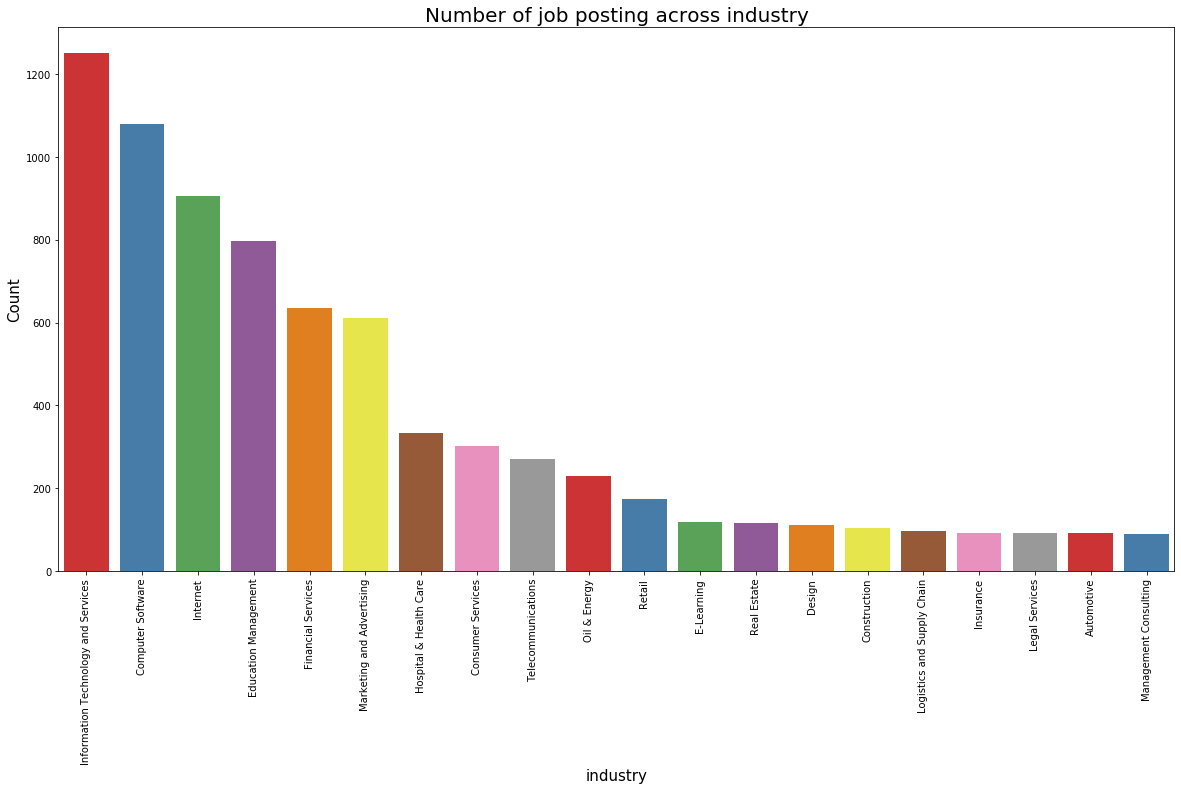

In [86]:
# check number of job posting across industry
count_jobs = data.groupby(["industry"], as_index=False).agg({'title':'count'}).sort_values('title', ascending = False).head(20)

# plot
plt.rcParams["figure.figsize"] = (20,10)

# plt.bar(count_jobs.industry, count_jobs.title, color="Set1")
g = sns.barplot("industry", "title", data=count_jobs, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Number of job posting across industry", fontsize=20)
g.set_xlabel("industry", fontsize=15)
g.set_ylabel("Count", fontsize=15)

### Frequency distribution plot

#### Check if the lenght of the job posts varies for legit and fraud posts 

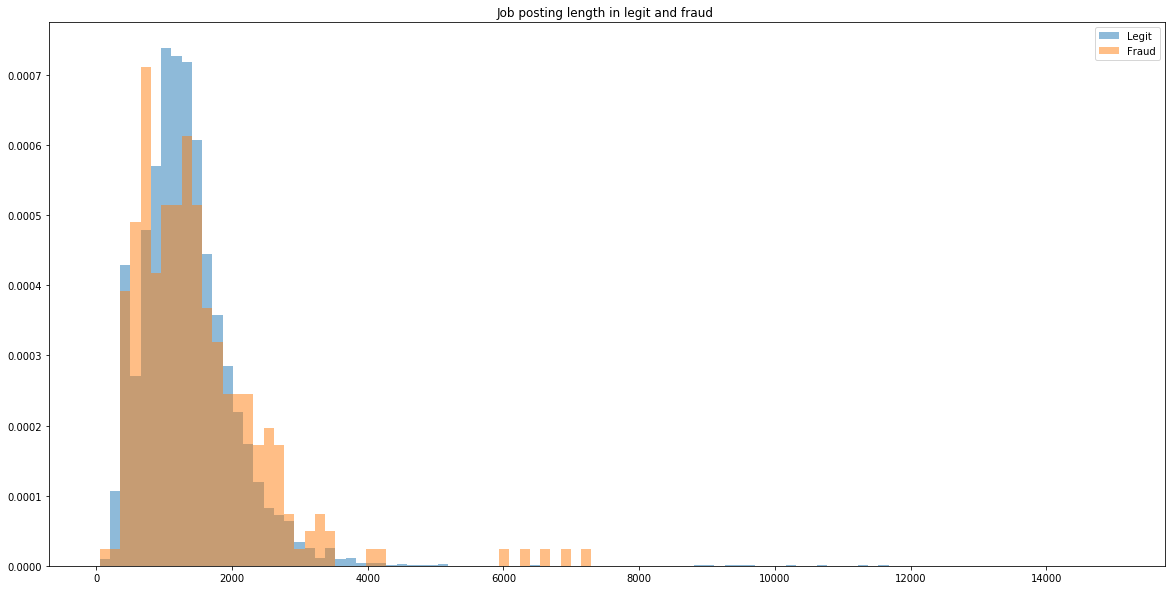

In [87]:
data['body_len'] = data['concat'].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(50, 15000, 100)

pyplot.hist(data[data['fraudulent']=='f']['body_len']**1/2, bins,  alpha=0.5,normed=True, label='Legit')
pyplot.hist(data[data['fraudulent']=='t']['body_len']**1/2, bins, alpha=0.5, normed=True, label='Fraud')
pyplot.legend(loc='upper right')
pyplot.title('Job posting length in legit and fraud ')
pyplot.show()

#### Check if the count of % punctuation of the job posts varies for legit and fraud posts 

In [88]:
def count_punct(text):
    """
    This function calculates number of punctuation from posts 
    param:text: job posts
    
    Return: % count of punctuation
    """
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['punct%'] = data['concat'].apply(lambda x: count_punct(x))

# min and max % of punctuations 
data['punct%'].min(), data['punct%'].max()

(2.0, 26.3)

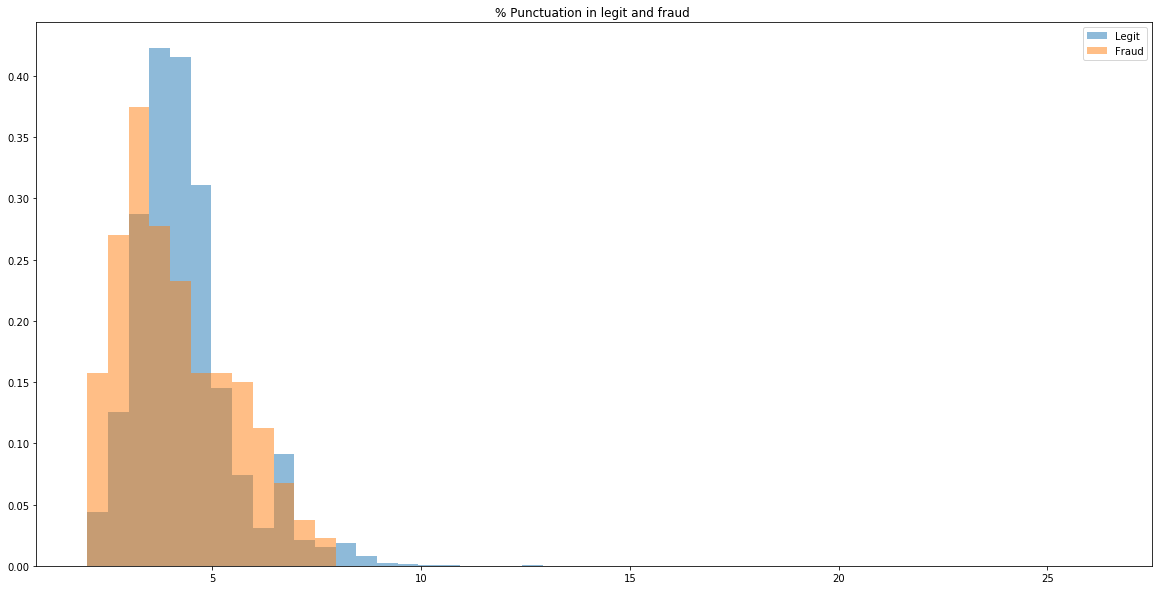

In [89]:
bins = np.linspace(2, 26.3, 50)

data['punct%'] = data['concat'].apply(lambda x: count_punct(x))
pyplot.hist(data[data['fraudulent']=='f']['punct%']**1/2, bins,  alpha=0.5,normed=True, label='Legit')
pyplot.hist(data[data['fraudulent']=='t']['punct%']**1/2, bins, alpha=0.5, normed=True, label='Fraud')
pyplot.title('% Punctuation in legit and fraud ')
pyplot.legend(loc='upper right')

## Data Cleaning and preprocessing 

In this step the data is cleaned to remove stop words, punctuation, html tags and gibberish

In [90]:
# create a contraction map dictionary 
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [91]:
def clean_text(text):
    """
    This function remove the htmp tags and gibberish words from the data and performs stemming, function called from TD-IDF
    
    :param:text: job posting 
    
    :return: tokens
    """
    
    tokens = []
    try:
        # remove html tags
        # anything that starts with <, has a set of characters [a-z], starts with (^) < 
        # has one or more occurances (+) and having one of more repetition (?)
        text = re.sub('<[^<]+?>', '', text)
        
        text = "".join([word for word in text if word not in string.punctuation and word not in ['li', 'amp', 'br', "pb", "bp", "pp", "bb"]])

        tokens = re.split('\W+', text)
        
        # perform steming on the words
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens if word not in stopwords and word not in ""]

    except:
        pass
    return tokens

In [92]:
def spacy_cleaner(text):
    """
    This function clean the sentences for email. punctuation, phone numbers and reconstructs the sentence back for sentence clustering
    :param:text: job posts sentence
    
    :return: cleaned sentences

    """
    # perfrom contraction mapping
    apostrophe_handled = re.sub("’", "'", text)

    apostrophe_handled = apostrophe_handled.replace(".", " ")
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    
    # remove punctuations
    exapnded = "".join([word for word in text if word not in string.punctuation])

    parsed = nlp(expanded)
    
    final_tokens = []
    # for every parsed word
    for t in parsed:
        # check if url, @ or trademark,remove from sentence if true
        if t.is_punct or t.is_space or t.like_url or str(t).startswith('@') or str(t) =='®':
            pass
        # if the str contains url, replace with ''
        elif str(t).__contains__('#url'):
            return ''

        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                #lemmatized the sentence
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                
                # remove gibberish from sentence
                if sc_removed not in ['li', 'amp', 'br', "pb", "bp", "bs",
                                      "pp", "bb", "urlfafceadeaecaedbdfefaae", 
                                      "phoneaadcbcadbebadafed", "emaildfeedfcddfcabcdbbdcbfadc", 
                                      "emailbacfdcecbdabdecdbcadfbeaccdarren", "emaildfeedfcddfcabcdbbdcbfadc"]:
                    
                    if len(sc_removed) > 1:
                        final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [93]:
def remove_html_tags(text):
    """
    This function removes tags from the text
    
    :param: text: Job posts
    :return: text without html
    """
    return re.sub('<[^<]+?>', '', str(text))


data.company_profile=data.company_profile.apply(remove_html_tags).str.replace('\r\n', '').str.lower()
data.description=data.description.apply(remove_html_tags).str.replace('\r\n', '').str.lower()
data.requirements=data.requirements.apply(remove_html_tags).str.replace('\r\n', '').str.lower()
data.benefits=data.benefits.apply(remove_html_tags).str.replace('\r\n', '').str.lower()
data.head(2)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,concat,body_len,punct%
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"we're food52, and we've created a groundbreaking and award-winning cooking site. we support, con...","food52, a fast-growing, james beard award-winning online food community and crowd-sourced and cu...",experience with content management systems a major plus (any blogging counts!)familiar with the ...,nan,f,t,...,Other,Internship,NaN,NaN,Marketing,f,f,"<h3>We're Food52, and we've created a groundbreaking and award-winning cooking site. We support,...",2530,7.9
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 seconds, the worlds cloud video production service.90 seconds is the worlds cloud video produ...",organised - focused - vibrant - awesome!do you have a passion for customer service? slick typing...,"what we expect from you:your key responsibility will be to communicate with the client, 90 secon...",what you will get from usthrough being part of the 90 seconds team you will gain:experience work...,f,t,...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f,"<h3>90 Seconds, the worlds Cloud Video Production Service.</h3>\r\n<p>90 Seconds is the worlds C...",5214,8.7


### Sentence Clustering

#### Create two different lists with total sentences, legit and fraud across requirements, company profile, description and benefits column

In [94]:
# make a list of the sentences 
sentences = []
fraud_sent = []
legit_sent = []
sent = {}
column_list = ['requirements', 'company_profile', 'description', 'benefits'] 
#loop across column lists
for column in column_list:
    sub = data[(data[column].notnull()) & (data['industry'] =='Oil & Energy')].reset_index(drop=True)
    # loop across all the posts
    for x in range(0,len(sub)):
        analyzed_doc = model(sub[column][x])
        
        # loop across every sentence within the post
        for sentence in analyzed_doc.sents:
            cleaned = spacy_cleaner(sentence.text.lower())
            # remove short and null sentences (short sentences are usually just words)
            if (cleaned == "") or (len(cleaned) < 15):
                pass
            else:
                # append in the list of fraud or legit sentences
                if sub['fraudulent'][x] == 'f':
                    legit_sent.append(cleaned)
                else:
                    fraud_sent.append(cleaned)

sentences = fraud_sent + legit_sent

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


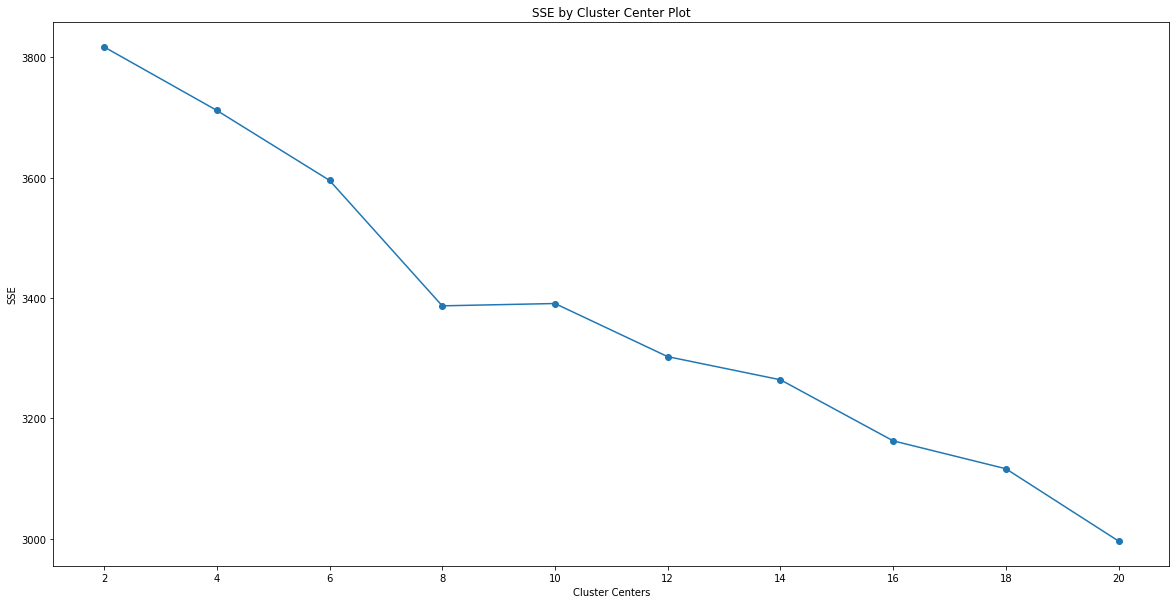

In [96]:
from sklearn.cluster import MiniBatchKMeans

def find_optimal_clusters(data, max_k):
    """
    This func plots SSE for the n number of clusters 
    
    :param: data : sentences 
    :max_k: number of clusters to iter over
    
    :return: 
    """
    tfidf_vectorizer = TfidfVectorizer(tokenizer=clean_text,
                                    stop_words=stopwords,
                                    max_df=0.9,
                                    max_features = 8000,

                                    lowercase=True)
    #builds a tf-idf matrix for the sentences
    tfidf_matrix = tfidf_vectorizer.fit_transform(data)
    words = tfidf_vectorizer.get_feature_names()
    
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(tfidf_matrix).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(sentences, 20)

In [97]:
# remove the short sentences 
sentences = [sent for sent in sentences if sent not in ['', 'li'] if len(sent) > 20]

In [101]:
def cluster_sentences(sentences, nb_of_clusters=5):
    """
    This function performs word vectorization and kmeans clustering
    
    :param:sentences: list of sentences
    :nb_of_clusters: total number of clusters
    :return: clusters
    """
    # perform sentence tokenization
    tfidf_vectorizer = TfidfVectorizer(tokenizer=clean_text,
                                    stop_words=stopwords,
                                    max_df=0.9,
#                                     min_df=0.1,
#                                        ngram_range = (2,2),
                                    max_features = 8000,

                                    lowercase=True)
    #builds a tf-idf matrix for the sentences
    tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
    
    # get feature names
    words = tfidf_vectorizer.get_feature_names()
    
    # performs kmeans clustering
    kmeans = KMeans(n_clusters=nb_of_clusters)
    kmeans.fit(tfidf_matrix)
    clusters = collections.defaultdict(list)
    for i, label in enumerate(kmeans.labels_):
            clusters[label].append(i)
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
    
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))
    return dict(clusters)

num_of_clusters = 16
clusters = cluster_sentences(sentences, nb_of_clusters=num_of_clusters)
counts = {f'cluster_{i}' : [["legit", 0] , ["fraud",0]] for i in range(num_of_clusters)}


0 : recruit, middl, east, consult, vp, emaildfeedfcddfcabcdbbdcbfadc, agenc, becom, array, special
1 : free, tax, year, compani, corpor, sinc, enlarg, london, colleagu, click
2 : solut, ga, oil, industri, provid, servic, workforc, across, special, focu
3 : go, inform, peopl, busi, valu, individu, prepar, take, look, posit
4 : step, employ, remain, everi, final, way, involv, sign, throughout, contact
5 : experi, year, minimum, requir, engin, degre, prefer, militari, orb, educ
6 : opportun, energi, advanc, one, job, compani, grow, appli, join, candid
7 : packag, compens, candid, benefit, avail, referr, refin, strong, resourc, bonu
8 : thank, wish, mani, cooper, good, ford, formerli, former, format, formalis
9 : mission, success, valor, servic, ford, formerli, former, format, formalis, formal
10 : project, work, develop, manag, oper, requir, team, engin, perform, equip
11 : interview, phone, skype, attend, onlypleas, face, appli, locat, email, consid
12 : discoveri, bring, recoveri, maxim

In [102]:
# Calculate the legit and fraud sentences within the cluster
for cluster in range(0,num_of_clusters):

    for i,sentence in enumerate(clusters[cluster]):
        if (sentences[sentence] == "") or (len(sentences[sentence]) < 10):
            pass
        else:
            
            if sentences[sentence] in legit_sent:

                counts[f'cluster_{cluster}'][0][1] +=  1
            else:

                counts[f'cluster_{cluster}'][1][1] += 1

Count of legit and fraud sentences

In [103]:
counts

{'cluster_0': [['legit', 72], ['fraud', 23]],
 'cluster_1': [['legit', 120], ['fraud', 72]],
 'cluster_2': [['legit', 107], ['fraud', 68]],
 'cluster_3': [['legit', 0], ['fraud', 54]],
 'cluster_4': [['legit', 106], ['fraud', 0]],
 'cluster_5': [['legit', 232], ['fraud', 56]],
 'cluster_6': [['legit', 81], ['fraud', 44]],
 'cluster_7': [['legit', 74], ['fraud', 87]],
 'cluster_8': [['legit', 29], ['fraud', 18]],
 'cluster_9': [['legit', 107], ['fraud', 0]],
 'cluster_10': [['legit', 1155], ['fraud', 887]],
 'cluster_11': [['legit', 100], ['fraud', 18]],
 'cluster_12': [['legit', 0], ['fraud', 63]],
 'cluster_13': [['legit', 107], ['fraud', 0]],
 'cluster_14': [['legit', 0], ['fraud', 63]],
 'cluster_15': [['legit', 96], ['fraud', 69]]}